# 1. 데이터 로드

### 주요 import 할것들 미리 해두기 (나머지는 그때그때)

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime as dt
from datetime import timedelta as td

from tqdm.notebook import tqdm

In [2]:
import utils

### 경로 등 global config 설정

In [3]:
RAW_ROOT = 'raw'
DATA_ROOT = 'data'

### 각종 데이터 불러오기

In [4]:
%%time
df_user_CV = pd.read_parquet(f'{DATA_ROOT}/df_user_aggregated_CV.pq')
df_user_LB = pd.read_parquet(f'{DATA_ROOT}/df_user_aggregated_LB.pq')
df_item_CV = pd.read_parquet(f'{DATA_ROOT}/df_item_aggregated_CV.pq')
df_item_LB = pd.read_parquet(f'{DATA_ROOT}/df_item_aggregated_LB.pq')
df_log_all = pd.read_parquet(f'{DATA_ROOT}/df_log_preprocessed.pq')
df_log_CV = utils.get_df_log_of(df_log_all, 'CV')
df_log_LB = utils.get_df_log_of(df_log_all, 'LB')

CPU times: user 29.2 s, sys: 53 s, total: 1min 22s
Wall time: 1min 24s


In [5]:
del df_log_all

---

# 2. CV 테스트 환경 및 서브밋 환경

### CV 테스트 정답셋

In [6]:
%%time
df_log_CV_test = df_log_CV[df_log_CV['target'] == 'test']
df_log_CV_train_valid = df_log_CV[df_log_CV['target'] != 'test']

CPU times: user 4.87 s, sys: 5.81 s, total: 10.7 s
Wall time: 10.8 s


In [7]:
uid2aiidset_CV = {}

In [8]:
%%time
for row in df_log_CV_test[['customer_id', 'article_id']].itertuples():
    _, uid, iid = row
    if uid not in uid2aiidset_CV:
        uid2aiidset_CV[uid] = set()
    uid2aiidset_CV[uid].add(iid)

CPU times: user 638 ms, sys: 20.3 ms, total: 658 ms
Wall time: 690 ms


# 3. Recent Week Popular 분석

### CV 버전

4-week best

In [9]:
df_resource_CV = pd.read_csv('data/resources/RWP_WC4_CV.csv')

In [10]:
df_resource_CV.set_index('customer_id', inplace=True)

In [11]:
APs = []
for uid, aiidset in uid2aiidset_CV.items():
    prediction = df_resource_CV.loc[uid, 'prediction'].split(' ')
    AP = utils.calc_ap(aiidset, prediction)
    APs.append(AP)
APs = np.array(APs)

분포 눈으로 확인

<AxesSubplot:ylabel='Frequency'>

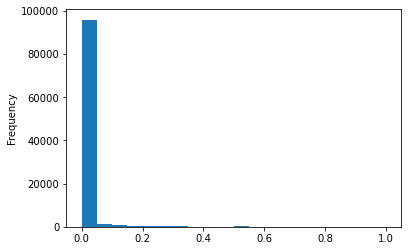

In [12]:
pd.Series(APs).plot.hist(bins=20)

percentile로 정확히 짚기

In [13]:
np.percentile(APs, 90)

0.0

알고보니 0점과 아닌것만 나누면 되는거임ㅋㅋ

다시 정확하게 분석하자 이제...

In [14]:
uids_pos = []
uids_neg = []
for uid, aiidset in uid2aiidset_CV.items():
    prediction = df_resource_CV.loc[uid, 'prediction'].split(' ')
    AP = utils.calc_ap(aiidset, prediction)
    if AP:
        uids_pos.append(uid)
    else:
        uids_neg.append(uid)
print(f"0점이 아닌 사람 :{len(uids_pos)}")
print(f"0점인 사람: {len(uids_neg)}")

0점이 아닌 사람 :5984
0점인 사람: 93105


트리 학습

In [15]:
from sklearn.tree import DecisionTreeClassifier

In [16]:
df_user_feature = pd.read_parquet(f'{DATA_ROOT}/df_user_feature_CV.pq')

In [17]:
df_user_feature = df_user_feature[df_user_feature.index.isin(uids_pos + uids_neg)]

In [18]:
labels = [1] * len(uids_pos) + [0] * len(uids_neg)

In [19]:
clf = DecisionTreeClassifier()
clf = clf.fit(df_user_feature, labels)

트리 결과 분석

In [20]:
temp_rows = []
for column, importance in zip(df_user_feature.columns, clf.feature_importances_):
    temp_rows.append((column, importance))
df_temp = pd.DataFrame(temp_rows)
df_temp.columns = ['feature', 'importance']

In [21]:
df_temp[df_temp['importance'] > 0.02].sort_values('importance', ascending=False)

,feature,importance
28,avg_price,0.075341
31,last_active_week,0.050235
30,log_transaction_count,0.046860
10,garment_prob_1005,0.044853
14,garment_prob_1009,0.042730
4,cohort_prob_1,0.040654
2,online_prob,0.040030
5,cohort_prob_2,0.039317
15,garment_prob_1010,0.038837
8,garment_prob_1002,0.038256


리그레션도 한번 해보자

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
clf = LogisticRegression(max_iter=1000).fit(df_user_feature, labels)

리그레션 결과 분석

In [24]:
temp_rows = []
for column, coef in zip(df_user_feature.columns, clf.coef_[0]):
    temp_rows.append((column, coef))
df_temp = pd.DataFrame(temp_rows)
df_temp.columns = ['feature', 'coef']

In [25]:
df_temp.sort_values('coef', ascending=False)

,feature,coef
1,age_gmm_2,0.665825
9,garment_prob_1003,0.300810
12,garment_prob_1007,0.211666
18,garment_prob_1013,0.200421
29,is_new,0.191631
7,cohort_prob_4,0.153230
27,garment_prob_1025,0.149469
25,garment_prob_1021,0.118190
8,garment_prob_1002,0.098793
22,garment_prob_1018,0.090837


두 그룹의 분포 차이를 좀 봅시다

In [26]:
df_user = pd.read_parquet(f'{DATA_ROOT}/df_user_preprocessed.pq')
df_user['label'] = 'pos'
df_user.loc[df_user.index.isin(uids_neg), 'label'] = 'neg'
df_user_pos = df_user[df_user['label'] == 'pos']
df_user_neg = df_user[df_user['label'] == 'neg']

<AxesSubplot:xlabel='FN', ylabel='portion'>

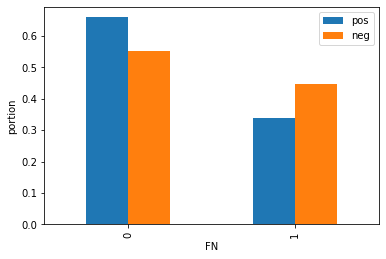

In [27]:
field = 'FN'

s_pos = df_user_pos[field].value_counts()
s_neg = df_user_neg[field].value_counts()
pd.DataFrame({
    'label': ['pos', 'neg'],
    'pos': s_pos.values / s_pos.sum(),
    'neg': s_neg.values / s_neg.sum(),
}).plot(kind='bar', xlabel=field, ylabel='portion')

<AxesSubplot:xlabel='Active', ylabel='portion'>

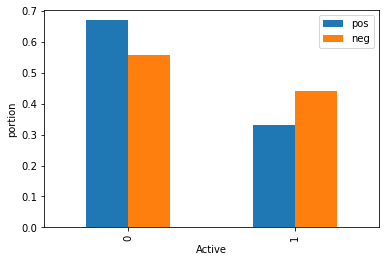

In [28]:
field = 'Active'

s_pos = df_user_pos[field].value_counts()
s_neg = df_user_neg[field].value_counts()
pd.DataFrame({
    'label': ['pos', 'neg'],
    'pos': s_pos.values / s_pos.sum(),
    'neg': s_neg.values / s_neg.sum(),
}).plot(kind='bar', xlabel=field, ylabel='portion')

<AxesSubplot:xlabel='club_member_status', ylabel='portion'>

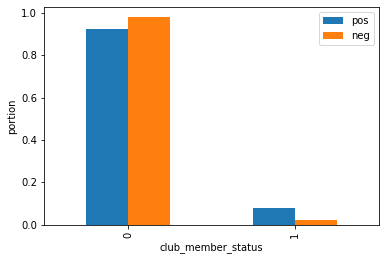

In [29]:
field = 'club_member_status'

s_pos = df_user_pos[field].value_counts()
s_neg = df_user_neg[field].value_counts()
pd.DataFrame({
    'label': ['pos', 'neg'],
    'pos': s_pos.values / s_pos.sum(),
    'neg': s_neg.values / s_neg.sum(),
}).plot(kind='bar', xlabel=field, ylabel='portion')

<AxesSubplot:xlabel='fashion_news_frequency', ylabel='portion'>

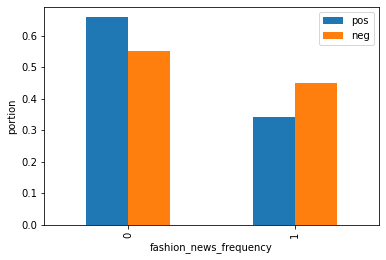

In [30]:
field = 'fashion_news_frequency'

s_pos = df_user_pos[field].value_counts()
s_neg = df_user_neg[field].value_counts()
pd.DataFrame({
    'label': ['pos', 'neg'],
    'pos': s_pos.values / s_pos.sum(),
    'neg': s_neg.values / s_neg.sum(),
}).plot(kind='bar', xlabel=field, ylabel='portion')

CPU times: user 32.9 s, sys: 5.09 s, total: 38 s
Wall time: 31.8 s


label
neg    AxesSubplot(0.125,0.125;0.775x0.755)
pos    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

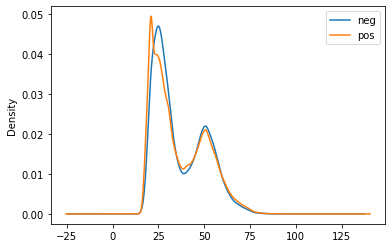

In [31]:
%%time
field = 'age'
df_user.groupby('label')[field].plot.kde(xlabel=field, legend=True)

In [32]:
df_user_feature
df_user_feature['label'] = 'pos'
df_user_feature.loc[df_user_feature.index.isin(uids_neg), 'label'] = 'neg'

CPU times: user 4.14 s, sys: 1.89 s, total: 6.03 s
Wall time: 2.72 s


label
neg    AxesSubplot(0.125,0.125;0.775x0.755)
pos    AxesSubplot(0.125,0.125;0.775x0.755)
Name: online_prob, dtype: object

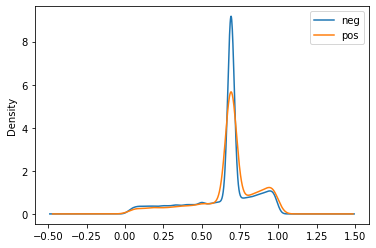

In [33]:
%%time
field = 'online_prob'
df_user_feature.groupby('label')[field].plot.kde(xlabel=field, legend=True)

CPU times: user 3.5 s, sys: 1.77 s, total: 5.27 s
Wall time: 2.13 s


label
neg    AxesSubplot(0.125,0.125;0.775x0.755)
pos    AxesSubplot(0.125,0.125;0.775x0.755)
Name: avg_price, dtype: object

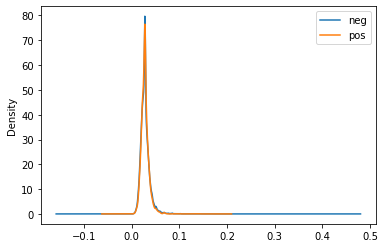

In [34]:
%%time
field = 'avg_price'
df_user_feature.groupby('label')[field].plot.kde(xlabel=field, legend=True)

CPU times: user 3.88 s, sys: 1.82 s, total: 5.7 s
Wall time: 2.68 s


label
neg    AxesSubplot(0.125,0.125;0.775x0.755)
pos    AxesSubplot(0.125,0.125;0.775x0.755)
Name: log_transaction_count, dtype: object

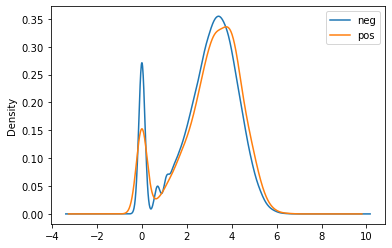

In [35]:
%%time
field = 'log_transaction_count'
df_user_feature.groupby('label')[field].plot.kde(xlabel=field, legend=True)

CPU times: user 3.91 s, sys: 1.85 s, total: 5.76 s
Wall time: 2.62 s


label
neg    AxesSubplot(0.125,0.125;0.775x0.755)
pos    AxesSubplot(0.125,0.125;0.775x0.755)
Name: last_active_week, dtype: object

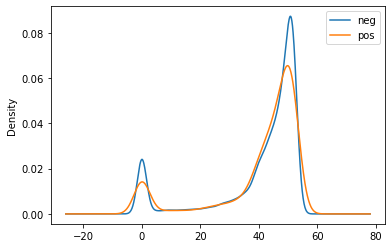

In [36]:
%%time
field = 'last_active_week'
df_user_feature.groupby('label')[field].plot.kde(xlabel=field, legend=True)

In [37]:
del df_temp
del clf
del df_user
del df_user_feature

In [38]:
del uids_pos
del uids_neg
del APs
del df_resource_CV

---

# 4. Recent Bought 분석

### CV 버전

8-week cut

In [39]:
df_resource_CV = pd.read_csv('data/resources/RB_WC8_CV.csv')

In [40]:
df_resource_CV.set_index('customer_id', inplace=True)

In [41]:
APs = []
for uid, aiidset in uid2aiidset_CV.items():
    try:
        prediction = df_resource_CV.loc[uid, 'prediction'].split(' ')
    except:
        continue
    AP = utils.calc_ap(aiidset, prediction)
    APs.append(AP)
APs = np.array(APs)

분포 눈으로 확인

<AxesSubplot:ylabel='Frequency'>

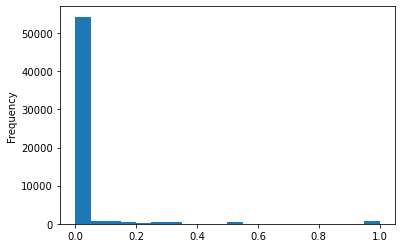

In [42]:
pd.Series(APs).plot.hist(bins=20)

percentile로 정확히 짚기

In [43]:
np.percentile(APs, 90)

0.0

여기도 0점과 아닌것이네..

In [44]:
uids_pos = []
uids_neg = []
for uid, aiidset in uid2aiidset_CV.items():
    try:
        prediction = df_resource_CV.loc[uid, 'prediction'].split(' ')
    except:
        continue
    AP = utils.calc_ap(aiidset, prediction)
    if AP:
        uids_pos.append(uid)
    else:
        uids_neg.append(uid)
print(f"0점이 아닌 사람 :{len(uids_pos)}")
print(f"0점인 사람: {len(uids_neg)}")

0점이 아닌 사람 :5642
0점인 사람: 53209


트리 학습

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
df_user_feature = pd.read_parquet(f'{DATA_ROOT}/df_user_feature_CV.pq')

In [47]:
df_user_feature = df_user_feature[df_user_feature.index.isin(uids_pos + uids_neg)]

In [48]:
labels = [1] * len(uids_pos) + [0] * len(uids_neg)

In [49]:
clf = DecisionTreeClassifier()
clf = clf.fit(df_user_feature, labels)

트리 결과 분석

In [50]:
temp_rows = []
for column, importance in zip(df_user_feature.columns, clf.feature_importances_):
    temp_rows.append((column, importance))
df_temp = pd.DataFrame(temp_rows)
df_temp.columns = ['feature', 'importance']

In [51]:
df_temp[df_temp['importance'] > 0.02].sort_values('importance', ascending=False)

,feature,importance
28,avg_price,0.061876
30,log_transaction_count,0.046592
2,online_prob,0.046185
8,garment_prob_1002,0.045714
15,garment_prob_1010,0.044559
14,garment_prob_1009,0.044369
10,garment_prob_1005,0.043292
21,garment_prob_1017,0.043218
5,cohort_prob_2,0.042660
4,cohort_prob_1,0.040854


리그레션도 한번 해보자

In [52]:
from sklearn.linear_model import LogisticRegression

In [53]:
clf = LogisticRegression(max_iter=1000).fit(df_user_feature, labels)

리그레션 결과 분석

In [54]:
temp_rows = []
for column, coef in zip(df_user_feature.columns, clf.coef_[0]):
    temp_rows.append((column, coef))
df_temp = pd.DataFrame(temp_rows)
df_temp.columns = ['feature', 'coef']

In [55]:
df_temp.sort_values('coef', ascending=False)

,feature,coef
1,age_gmm_2,0.553742
20,garment_prob_1016,0.328884
9,garment_prob_1003,0.321685
18,garment_prob_1013,0.241348
32,FN_0,0.190858
25,garment_prob_1021,0.188943
7,cohort_prob_4,0.113940
15,garment_prob_1010,0.104045
24,garment_prob_1020,0.102407
8,garment_prob_1002,0.096769


두 그룹의 분포 차이를 좀 봅시다

In [56]:
df_user = pd.read_parquet(f'{DATA_ROOT}/df_user_preprocessed.pq')
df_user['label'] = 'pos'
df_user.loc[df_user.index.isin(uids_neg), 'label'] = 'neg'
df_user_pos = df_user[df_user['label'] == 'pos']
df_user_neg = df_user[df_user['label'] == 'neg']

<AxesSubplot:xlabel='FN', ylabel='portion'>

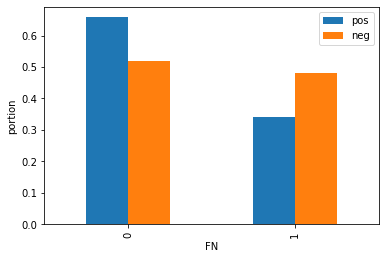

In [57]:
field = 'FN'

s_pos = df_user_pos[field].value_counts()
s_neg = df_user_neg[field].value_counts()
pd.DataFrame({
    'label': ['pos', 'neg'],
    'pos': s_pos.values / s_pos.sum(),
    'neg': s_neg.values / s_neg.sum(),
}).plot(kind='bar', xlabel=field, ylabel='portion')

<AxesSubplot:xlabel='Active', ylabel='portion'>

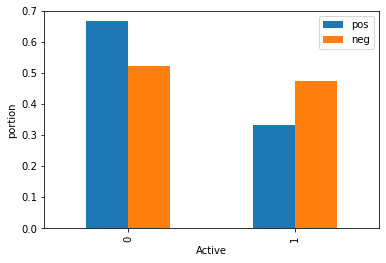

In [58]:
field = 'Active'

s_pos = df_user_pos[field].value_counts()
s_neg = df_user_neg[field].value_counts()
pd.DataFrame({
    'label': ['pos', 'neg'],
    'pos': s_pos.values / s_pos.sum(),
    'neg': s_neg.values / s_neg.sum(),
}).plot(kind='bar', xlabel=field, ylabel='portion')

<AxesSubplot:xlabel='club_member_status', ylabel='portion'>

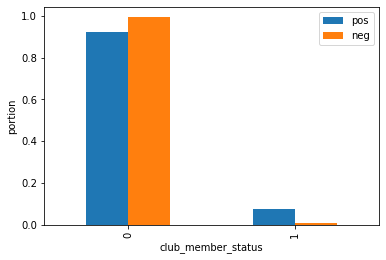

In [59]:
field = 'club_member_status'

s_pos = df_user_pos[field].value_counts()
s_neg = df_user_neg[field].value_counts()
pd.DataFrame({
    'label': ['pos', 'neg'],
    'pos': s_pos.values / s_pos.sum(),
    'neg': s_neg.values / s_neg.sum(),
}).plot(kind='bar', xlabel=field, ylabel='portion')

<AxesSubplot:xlabel='fashion_news_frequency', ylabel='portion'>

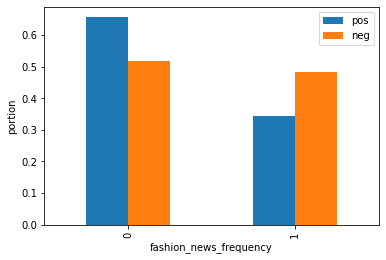

In [60]:
field = 'fashion_news_frequency'

s_pos = df_user_pos[field].value_counts()
s_neg = df_user_neg[field].value_counts()
pd.DataFrame({
    'label': ['pos', 'neg'],
    'pos': s_pos.values / s_pos.sum(),
    'neg': s_neg.values / s_neg.sum(),
}).plot(kind='bar', xlabel=field, ylabel='portion')

CPU times: user 33.6 s, sys: 3.92 s, total: 37.5 s
Wall time: 31.5 s


label
neg    AxesSubplot(0.125,0.125;0.775x0.755)
pos    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

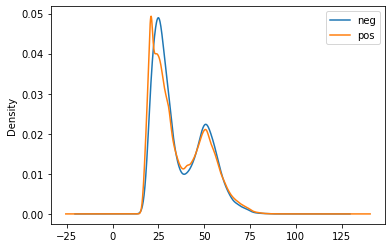

In [61]:
%%time
field = 'age'
df_user.groupby('label')[field].plot.kde(xlabel=field, legend=True)

In [62]:
df_user_feature
df_user_feature['label'] = 'pos'
df_user_feature.loc[df_user_feature.index.isin(uids_neg), 'label'] = 'neg'

CPU times: user 2.84 s, sys: 1.71 s, total: 4.54 s
Wall time: 1.6 s


label
neg    AxesSubplot(0.125,0.125;0.775x0.755)
pos    AxesSubplot(0.125,0.125;0.775x0.755)
Name: online_prob, dtype: object

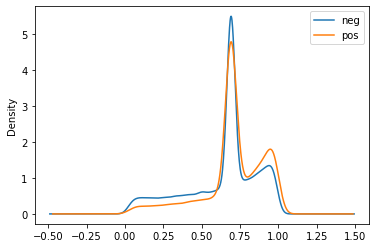

In [63]:
%%time
field = 'online_prob'
df_user_feature.groupby('label')[field].plot.kde(xlabel=field, legend=True)

CPU times: user 2.52 s, sys: 1.82 s, total: 4.34 s
Wall time: 1.28 s


label
neg    AxesSubplot(0.125,0.125;0.775x0.755)
pos    AxesSubplot(0.125,0.125;0.775x0.755)
Name: avg_price, dtype: object

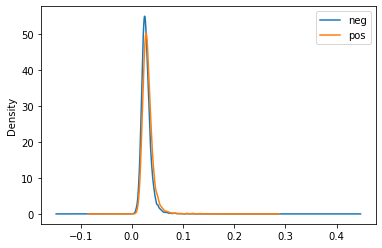

In [64]:
%%time
field = 'avg_price'
df_user_feature.groupby('label')[field].plot.kde(xlabel=field, legend=True)

CPU times: user 2.94 s, sys: 1.9 s, total: 4.84 s
Wall time: 1.63 s


label
neg    AxesSubplot(0.125,0.125;0.775x0.755)
pos    AxesSubplot(0.125,0.125;0.775x0.755)
Name: log_transaction_count, dtype: object

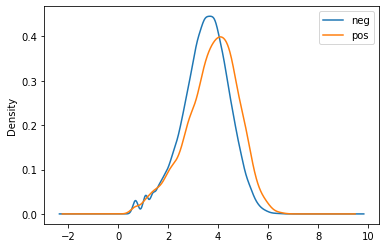

In [65]:
%%time
field = 'log_transaction_count'
df_user_feature.groupby('label')[field].plot.kde(xlabel=field, legend=True)

CPU times: user 2.86 s, sys: 2 s, total: 4.87 s
Wall time: 1.59 s


label
neg    AxesSubplot(0.125,0.125;0.775x0.755)
pos    AxesSubplot(0.125,0.125;0.775x0.755)
Name: last_active_week, dtype: object

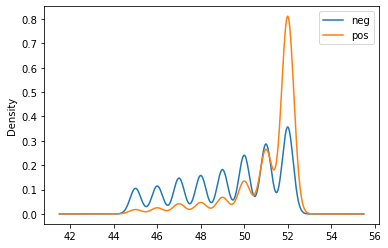

In [66]:
%%time
field = 'last_active_week'
df_user_feature.groupby('label')[field].plot.kde(xlabel=field, legend=True)

In [67]:
del df_temp
del clf
del df_user_feature

In [68]:
del uids_pos
del uids_neg
del APs
del df_resource_CV